## Import Libraries
<ul>
<li><b>sqllite3</b> for interacting with a local relational database; and</li>
<li><b>pandas</b> and <b>numpy</b> for data ingestion and manipulation.</li>
<li><b>matplotlib</b> for data visualization</li>
<li>specific methods from <b>sklearn</b> for Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import re
import unicodedata

#### Ingest Data

Now, read the dataset using the commands below. 

In [2]:
fighters = pd.read_csv('fighter_basics.csv')

 <h1 style="font-size:2em;color:#2467C0">Exploring Data</h1>

In [3]:
fighters.columns

Index(['Name', 'Born', 'Height', 'Weight', 'Division', 'Reach', 'Style'], dtype='object')

In [4]:
fighters['Reach'][11]

'78\xa01⁄2\xa0in (199\xa0cm) [1]'

In [5]:
fighters['Birth_date'] = fighters['Born'].str.extract(r'(\d\d\d\d.\d\d.\d\d)')

In [6]:
fighters['Birth_date'].isnull().sum()

26

In [7]:
nan_rows = fighters[fighters['Birth_date'].isnull()]
#nan_rows

In [8]:
fighters['dob'] = pd.to_datetime(fighters['Birth_date'], errors='coerce')
now = pd.to_datetime('now')
fighters['Age']= (now - fighters['dob']).astype('<m8[Y]') 

In [9]:
fighters['Age'].isnull().sum()

26

In [10]:
fighters = fighters.drop(['Born', 'dob'], axis=1)

REMOVING THE ENCODING

In [11]:
fighters['Height']= fighters["Height"].apply(lambda x: unicodedata.normalize("NFKD", x))
fighters['Weight']= fighters["Weight"].apply(lambda x: unicodedata.normalize("NFKD", x))
fighters['Reach']= fighters["Reach"].apply(lambda x: unicodedata.normalize("NFKD", x))

In [12]:
fighters['Reach'][11]

'78 1⁄2 in (199 cm) [1]'

CONVERTING HEIGHT TO INCHES.

In [13]:
#r2 = re.compile(r"([0-9]+)\\xa0ft ([0-9]*\.?[0-9]+)\\xa0in")
def get_height(el):
    r = re.compile(r"([0-9]+) ft ([0-9]*\.?[0-9]+) in")
    m = r.match(el)
    if m == None:
        return float('NaN')
    else:
        return int(m.group(1))*12 + float(m.group(2))

In [14]:
fighters['Height'] = fighters["Height"].apply(lambda x: get_height(x))

CONVERTING WEIGHTS TO POUNDS AND REACH TO INCHES.

In [15]:
def get_weight(el):
    r = re.compile(r"([0-9]{2,3}\.?[0-9]+) lb")
    m = r.match(el)
    if m == None:
        return float('NaN')
    else:
        return float(m.group(1))
print(get_weight('255 lb (107 kg; 16 st 11 lb)'))

255.0


In [16]:
def get_reach(el):
    r = re.compile(r"([0-9]{1,2}\.?[0-9]+) in")
    m = r.match(el)
    if m == None:
        m = (re.compile(r"([0-9]{1,2}) .+ in")).match(el)
        if m != None:
            return int(m.group(1))+0.5
    elif m == None:
        return float('NaN')
    else:
        return float(m.group(1))
#print(get_reach(fighters['Reach'][11]))

In [17]:
fighters['Weight'] = fighters["Weight"].apply(lambda x: get_weight(x))
fighters['Reach'] = fighters["Reach"].apply(lambda x: get_reach(x))

In [18]:
fighters.head()

,Name,Height,Weight,Division,Reach,Style,Birth_date,Age
0,Leon Edwards,74.0,170.0,Middleweight Welterweight,74.0,Not Available,1991-08-25,27.0
1,Rafael dos Anjos,68.0,170.0,Lightweight (2004-2016) Welterweight (2017-pre...,70.0,"Brazilian Jiu-Jitsu, Muay Thai",1984-10-26,34.0
2,Walt Harris,77.0,258.0,Heavyweight,81.0,Not Available,1983-06-10,36.0
3,Aleksei Oleinik,74.0,235.0,HeavyweightLight heavyweightMiddleweight,80.0,"Combat Sambo, Jujutsu, Brazilian Jiu Jitsu",1977-06-25,42.0
4,Greg Hardy,77.0,265.0,Heavyweight,80.5,Boxing,1988-07-28,31.0


Curating Division column. Usually fighters go up to the class as they get older. So a Logic that fits this assumption is used to get Single division. Below is the list of current UFC divisions.


Strawweight
Flyweight
Bantamweight
Featherweight
Lightweight
Welterweight
Middleweight
Light Heavyweight
Heavyweight

In [19]:
Attribute = ['Strawweight', 'Flyweight', 'Bantamweight', 'Featherweight', 'Lightweight', 'Welterweight', 'Middleweight', 'Light heavyweight', 'Light Heavyweight', 'Heavyweight']

In [20]:
def get_division(el):
    cl = "None"
    for att in Attribute:
        if att in el:
            cl = att
    if cl == 'None':
        return float('NaN')
    else:
        return cl
#print(get_division('CruiserweightLight heavyweightSuper middleweight'))

In [21]:
fighters['Division'] = fighters["Division"].apply(lambda x: get_division(x))

Predicting weight class from weight.

In [22]:
#fighters

In [23]:
#Attribute = ['Strawweight', 'Flyweight', 'Bantamweight', 'Featherweight', 'Lightweight', 'Welterweight', 'Middleweight', 'Light heavyweight', 'Light Heavyweight', 'Heavyweight']
def check_weight(w):
    if w>90 and w<=115:
        return "Strawweight"
    elif w>115 and w<=125:
        return "Flyweight"
    elif w>125 and w<=135:
        return "Bantamweight"
    elif w>135 and w<=145:
        return "Featherweight"
    elif w>145 and w<=155:
        return "Lightweight"
    elif w>155 and w<=170:
        return "Welterweight"
    elif w>170 and w<=185:
        return "Middleweight"
    elif w>185 and w<=205:
        return "Light Heavyweight"
    elif w>205 and w<=265:
        return "Heavyweight"
    else:
        return float('NaN')

In [24]:
#def predict_division():
for i in range(len(fighters['Division'])):
    try:
        if pd.isnull(fighters['Division'][i]):
            #print(i)
            fighters['Division'][i] = check_weight(fighters['Weight'][i])
    except:
        pass

C:\Users\Sanij\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
#fighters

Now let's predict the missing height, weight and reach based on the average stats for that Division.

In [26]:
fighters['Height'] = fighters['Height'].fillna(fighters.groupby('Division')['Height'].transform('mean'))
fighters['Weight'] = fighters['Weight'].fillna(fighters.groupby('Division')['Weight'].transform('mean'))
fighters['Reach'] = fighters['Reach'].fillna(fighters.groupby('Division')['Reach'].transform('mean'))

In [27]:
fighters['Style'] = fighters['Style'].replace('Not Available', np.nan, regex=True)

In [28]:
fighters.columns

Index(['Name', 'Height', 'Weight', 'Division', 'Reach', 'Style', 'Birth_date',
       'Age'],
      dtype='object')

In [29]:
fighters.isnull().sum(axis=0)

Name            0
Height          9
Weight         12
Division       17
Reach          15
Style         942
Birth_date     26
Age            26
dtype: int64

# Which style is better in MMA?

List out the available styles <br>
Associate them with the methods of fight won.<br>
Predict the remaining fighters' style with an appropriate similarity measure.

In [30]:
features = ['Name', 'Style']

In [31]:
Yodha = fighters[features].copy(deep = True)

In [32]:
Yodha.head()

,Name,Style
0,Leon Edwards,NaN
1,Rafael dos Anjos,"Brazilian Jiu-Jitsu, Muay Thai"
2,Walt Harris,NaN
3,Aleksei Oleinik,"Combat Sambo, Jujutsu, Brazilian Jiu Jitsu"
4,Greg Hardy,Boxing


Find unique styles.

In [33]:
lisT= []
for style in Yodha['Style'].unique():
    try:
        for each in style.strip().split(','):
            if each.strip() not in lisT:
                lisT.append(each.strip())
    except:
        pass
#print(lisT)

Making list of ten popular martial arts style and their other names

BJJ = 'Brazilian Jiu-Jitsu', 'Jujutsu', 'Brazilian Jiu Jitsu', 'BJJ', 'Gaidojutsu', 'Jiu Jitsu', 'Brazilian jiu-jitsu', '10th Planet Jiu-Jitsu', '[4] BJJ[4]', 'Luta Livre', 'Purple belt in Brazilian Jiu-Jitsu[2]', 'Brazilian Jiu-jitsu', 'Kempo • Kickboxing • Jujutsu', 'Brazilian Jiu-Jitsu[3]', 'BJJ[1]', 'BJJ[2]', 'Brazilian Jiu-Jitsu[1]', 'Jiu-jitsu', 'BadgeJitsu', 'Brazilian Jiu-Jitsu  Muay Thai[2]', 'Gracie Jiu-Jitsu', 'GJJ', 'Jujitsu', 'Ju-Jitsu', 'BJJ[3]', 'Submission Fighting',
Muay Thai = 'Muay Thai', 'Muay Thai[1]', 'Muay Thai[2]', 'Muay Thai[6]', 'Brazilian Jiu-Jitsu  Muay Thai[2]', 
Sambo = 'Combat Sambo', 'Sambo', 'Submission Fighting',
Boxing = 'Boxing', 'boxing', 'Shootboxing', 'Tae Kwon Do  Boxing  Wing Chun',
Wrestling = 'Wrestling', 'Submission Wrestling', 'Freestyle Wrestling', 'Wrestling[3]', 'Submission wrestling', 'Greco-Roman Wrestling', 'Collegiate wrestling', 'Freestyle wrestling', 'Catch Wrestling', 'wrestling', 'Folkstyle Wrestling', 'Sanda and Freestyle Wrestling', 'Collegiate Wrestling', 'Pro Wrestling', 'Catch wrestling', 'Submission Wrestling.', 'Wrestling  Kickboxing', 'Submission Fighting', 'Shoot Wrestling', 'Amateur Wrestling', 'Shootfighting', 'Vovinam', 'Shooto', 
Grappling = 'Submission Fighting', 'Grappling', 'Submission grappling', 'Grappling[1]', '[1] Shuai Jiao', 'Shuai Jiao', 'Ssireum', 'Sumo', 
Kickboxing = 'Kickboxing', 'Kickboxing[3]', 'Kempo • Kickboxing • Jujutsu', 'Wrestling  Kickboxing', 'Sanda', 'Wushu Sanda', 'Sanshou and Wushu', 'Sanshou', 'Savate', 
Karate = 'Karate', 'Shotokan Karate', 'Kempo Karate', 'Kyokushin Karate', 'Kenpo Karate', 'American Kenpo Karate', 'Gōjū-ryū Karate', 'Kyokushin', 'Kung-Fu', 'Kung fu', 'Wushu', 
Judo = 'Judo', 'judo'
Taekwondo = 'Taekwondo', 'Tae Kwon Do', 'Tae Kwon Do  Boxing  Wing Chun', 'Jeet Kune Do', 


In [34]:
BJJ = np.asarray(['Brazilian Jiu-Jitsu', 'Jujutsu', 'Brazilian Jiu Jitsu', 'BJJ', 'Gaidojutsu', 'Jiu Jitsu', 'Brazilian jiu-jitsu', '10th Planet Jiu-Jitsu', '[4] BJJ[4]', 'Luta Livre', 'Purple belt in Brazilian Jiu-Jitsu[2]', 'Brazilian Jiu-jitsu', 'Kempo • Kickboxing • Jujutsu', 'Brazilian Jiu-Jitsu[3]', 'BJJ[1]', 'BJJ[2]', 'Brazilian Jiu-Jitsu[1]', 'Jiu-jitsu', 'BadgeJitsu', 'Brazilian Jiu-Jitsu Muay Thai[2]', 'Gracie Jiu-Jitsu', 'GJJ', 'Jujitsu', 'Ju-Jitsu', 'BJJ[3]', 'Submission Fighting'])
Muay_Thai = np.asarray(['Muay Thai', 'Muay Thai[1]', 'Muay Thai[2]', 'Muay Thai[6]', 'Brazilian Jiu-Jitsu Muay Thai[2]'])
Sambo = np.asarray(['Combat Sambo', 'Sambo', 'Submission Fighting']) 
Boxing = np.asarray(['Boxing', 'boxing', 'Shootboxing', 'Tae Kwon Do Boxing Wing Chun'])
Wrestling = np.asarray(['Wrestling', 'Submission Wrestling', 'Freestyle Wrestling', 'Wrestling[3]', 'Submission wrestling', 'Greco-Roman Wrestling', 'Collegiate wrestling', 'Freestyle wrestling', 'Catch Wrestling', 'wrestling', 'Folkstyle Wrestling', 'Sanda and Freestyle Wrestling', 'Collegiate Wrestling', 'Pro Wrestling', 'Catch wrestling', 'Submission Wrestling.', 'Wrestling Kickboxing', 'Submission Fighting', 'Shoot Wrestling', 'Amateur Wrestling', 'Shootfighting', 'Vovinam', 'Shooto'])
Grappling = np.asarray(['Submission Fighting', 'Grappling', 'Submission grappling', 'Grappling[1]', '[1] Shuai Jiao', 'Shuai Jiao', 'Ssireum', 'Sumo'])
Kickboxing = np.asarray(['Kickboxing', 'Kickboxing[3]', 'Kempo • Kickboxing • Jujutsu', 'Wrestling Kickboxing', 'Sanda', 'Wushu Sanda', 'Sanshou and Wushu', 'Sanshou', 'Savate'])
Karate = np.asarray(['Karate', 'Shotokan Karate', 'Kempo Karate', 'Kyokushin Karate', 'Kenpo Karate', 'American Kenpo Karate', 'Gōjū-ryū Karate', 'Kyokushin', 'Kung-Fu', 'Kung fu', 'Wushu'])
Judo = np.asarray(['Judo', 'judo'])
Taekwondo = np.asarray(['Taekwondo', 'Tae Kwon Do', 'Tae Kwon Do Boxing Wing Chun', 'Jeet Kune Do'])
Categories=np.asarray([BJJ, Muay_Thai, Sambo, Boxing, Wrestling, Grappling, Kickboxing, Karate, Judo, Taekwondo])

In [35]:
Categories_titles=np.asarray(['BJJ', 'Muay_Thai', 'Sambo', 'Boxing', 'Wrestling', 'Grappling', 'Kickboxing', 'Karate', 'Judo', 'Taekwondo'])

In [36]:
temp = pd.Series([0 for x in range(len(Yodha.index))])
for i in range(len(Yodha['Style'])):
    lisT1 = []
    try:
        for each in Yodha['Style'][i].split(','):
            for j in range(len(Categories)):
                if each.strip() in Categories[j]:
                    if Categories_titles[j] not in lisT1:
                        lisT1.append(Categories_titles[j])
        temp[i]= ', '.join(lisT1)
    except: 
        lisT1= float('NaN')
        temp[i] = lisT1

In [37]:
Yodha['Style'] = temp

In [38]:
Yodha.head(20)

,Name,Style
0,Leon Edwards,NaN
1,Rafael dos Anjos,"BJJ, Muay_Thai"
2,Walt Harris,NaN
3,Aleksei Oleinik,"Sambo, BJJ"
4,Greg Hardy,Boxing
5,Juan Adams,Wrestling
6,Dan Hooker,"Muay_Thai, BJJ"
7,James Vick,"Boxing, BJJ"
8,Alexander Hernandez,NaN
9,Francisco Trinaldo,"Kickboxing, Wrestling"


In [39]:
Yodha.shape

(1461, 2)

# Let's work with fights list now.

In [40]:
fights = pd.read_csv('fightsList.csv')

In [41]:
fights.head()

,Fighter_name,Result,Record,Opponent,Method,Event,Date,Round,Time
0,Leon Edwards,Win,18–3,Rafael dos Anjos,Decision (unanimous),UFC on ESPN: dos Anjos vs. Edwards,20 July 2019,5,5:00
1,Leon Edwards,Win,17–3,Gunnar Nelson,Decision (split),UFC Fight Night: Till vs. Masvidal,16 March 2019,3,5:00
2,Leon Edwards,Win,16–3,Donald Cerrone,Decision (unanimous),UFC Fight Night: Cowboy vs. Edwards,23 June 2018,5,5:00
3,Leon Edwards,Win,15–3,Peter Sobotta,TKO (punches),UFC Fight Night: Werdum vs. Volkov,17 March 2018,3,4:59
4,Leon Edwards,Win,14–3,Bryan Barberena,Decision (unanimous),UFC Fight Night: Volkov vs. Struve,2 September 2017,3,5:00


In [42]:
fights.columns

Index(['Fighter_name', 'Result', 'Record', 'Opponent', 'Method', 'Event',
       'Date', 'Round', 'Time'],
      dtype='object')

In [43]:
fights.index

RangeIndex(start=0, stop=35603, step=1)

In [44]:
fights.describe().transpose()

,count,unique,top,freq
Fighter_name,35603,1485,Travis Fulton,320
Result,35600,13,Win,24341
Record,35600,4622,1–0,1182
Opponent,35603,13295,Travis Fulton,50
Method,35548,820,Decision (unanimous),8218
Event,35602,15396,ShoXC: Elite Challenger Series,34
Date,35603,5473,"October 4, 2014",58
Round,35352,8,1,16211
Time,34028,666,5:00,10940


In [45]:
fights.shape

(35603, 9)

In [46]:
pd.unique(fights['Fighter_name']).shape

(1485,)

# Data Cleaning: Handling Missing Data

In [47]:
fights.isnull().any()

Fighter_name    False
Result           True
Record           True
Opponent        False
Method           True
Event            True
Date            False
Round            True
Time             True
dtype: bool

In [48]:
fights.isnull().sum(axis = 0)

Fighter_name       0
Result             3
Record             3
Opponent           0
Method            55
Event              1
Date               0
Round            251
Time            1575
dtype: int64

let's curate the data.<br> If there is no result, not worthy. Also remove anything beyond win or loss<br>
If there is no Method, fine!<br>
If there is no event, fine!<br>
If there is round and time, Let's see how they look and figure out if these can be predicted. <br>

In [49]:
fights = fights.dropna(subset=["Result"]).reset_index(drop = True)

In [50]:
fights['Result'].unique()

array(['Win', 'Loss', 'NC', 'Draw', 'Lose', 'loss', 'win', 'Winn', 'Won',
       'Los', 'xWin', 'Winx', 'Lossx'], dtype=object)

In [51]:
fights=fights[fights.Result != 'Draw']
fights= fights[fights.Result != 'NC']
fights = fights.reset_index(drop=True)

In [52]:
fights.isnull().sum(axis = 0)

Fighter_name       0
Result             0
Record             0
Opponent           0
Method            52
Event              1
Date               0
Round            228
Time            1521
dtype: int64

In [53]:
fights['Result'].unique()

array(['Win', 'Loss', 'Lose', 'loss', 'win', 'Winn', 'Won', 'Los', 'xWin',
       'Winx', 'Lossx'], dtype=object)

In [54]:
Win = np.asarray(['Win', 'win', 'Winn', 'Won', 'xWin', 'Winx'])
Loss = np.asarray(['Loss', 'Lose', 'loss', 'Los', 'Lossx'])
CateGory = np.asarray([Win, Loss])
CateGory_T = np.asarray(['Win', 'Loss'])

In [55]:
temp1 = pd.Series([0 for x in range(len(fights.index))])
for i in range(len(fights['Result'])):
    list = ''
    for j in [0,1]:
        if fights.loc[i,'Result'].strip() in CateGory[j]:
            list+= CateGory_T[j]
            break
    temp1[i] = list

In [56]:
fights['Result'] = temp1

In [57]:
fights.isnull().sum(axis = 0), fights.shape

(Fighter_name       0
 Result             0
 Record             0
 Opponent           0
 Method            52
 Event              1
 Date               0
 Round            228
 Time            1521
 dtype: int64, (34836, 9))

In [58]:
fights.loc[fights.Time.isnull(),:].head()
#NO they cannot be predicted

,Fighter_name,Result,Record,Opponent,Method,Event,Date,Round,Time
57,Rafael dos Anjos,Win,3–2,Diogo Oliveira,Submission (armbar),TFMMA - Top Fighter MMA 2,"October 25, 2006",2,NaN
59,Rafael dos Anjos,Win,2–1,Felipe Arinelli,TKO (doctor stoppage),Juiz de Fora - Fight 2,"April 26, 2005",2,NaN
118,Aleksei Oleinik,Win,18–3,Shamil Nurmagomedov,Submission (Ezekiel choke),Legion Fight 1,"October 20, 2007",1,NaN
225,Francisco Trinaldo,Win,3–0,Marcone Bezerra,Submission (arm-triangle choke),Hero's The Jungle 2,"April 7, 2008",1,NaN
226,Francisco Trinaldo,Win,2–0,Vinicius Dohrer,TKO (corner stoppage),Fight Club Tournament 3,"August 18, 2006",2,NaN


In [59]:
fights.columns

Index(['Fighter_name', 'Result', 'Record', 'Opponent', 'Method', 'Event',
       'Date', 'Round', 'Time'],
      dtype='object')

In [60]:
needed_attribute=['Fighter_name', 'Result', 'Method']

In [61]:
Jung = fights[needed_attribute].copy(deep = True)
Jung.isnull().sum(axis = 0), Jung.shape

(Fighter_name     0
 Result           0
 Method          52
 dtype: int64, (34836, 3))

In [62]:
Jung = Jung.dropna(subset=["Method"]).reset_index(drop = True)
Jung.isnull().sum(axis = 0), Jung.shape

(Fighter_name    0
 Result          0
 Method          0
 dtype: int64, (34784, 3))

Would like to extract what's inside brackets in Method column.<br>
Would like to group and count Wins and accumulate methods per fighter. <br>
Would like to group and count Losses and accumulate methods per fighter.

In [63]:
def get_method(el):
    try:
        r = re.compile(r'.*\((.*)\)$')
        m = r.match(el)
        if m == None:
            #print(el)
            return el
        else:
            return m.group(1)
    except:
        return el

In [64]:
get_method(Jung.loc[2313,:])

Fighter_name         Anthony Smith
Result                         Win
Method          Submission (choke)
Name: 2313, dtype: object

In [65]:
#Jung['Method1'] = pd.Series([0 for x in range(len(Jung.index))])
for i in range(len(Jung.index)):
    #print(i)
    Jung.loc[i,'Method']= get_method(Jung.loc[i,'Method'])

In [66]:
Jung.head(10)

,Fighter_name,Result,Method
0,Leon Edwards,Win,unanimous
1,Leon Edwards,Win,split
2,Leon Edwards,Win,unanimous
3,Leon Edwards,Win,punches
4,Leon Edwards,Win,unanimous
5,Leon Edwards,Win,unanimous
6,Leon Edwards,Win,rear-naked choke
7,Leon Edwards,Win,unanimous
8,Leon Edwards,Loss,unanimous
9,Leon Edwards,Win,unanimous


In [67]:
Jung['ID'] = Jung.groupby('Fighter_name').ngroup()
Jung.head()

,Fighter_name,Result,Method,ID
0,Leon Edwards,Win,unanimous,852
1,Leon Edwards,Win,split,852
2,Leon Edwards,Win,unanimous,852
3,Leon Edwards,Win,punches,852
4,Leon Edwards,Win,unanimous,852


In [68]:
#ID to name
ID_2_name = Jung[["ID", "Fighter_name"]].drop_duplicates()
ID_2_name.head()

,ID,Fighter_name
0,852,Leon Edwards
21,1138,Rafael dos Anjos
62,1437,Walt Harris
82,28,Aleksei Oleinik
129,519,Greg Hardy


In [69]:
Jung.head()

,Fighter_name,Result,Method,ID
0,Leon Edwards,Win,unanimous,852
1,Leon Edwards,Win,split,852
2,Leon Edwards,Win,unanimous,852
3,Leon Edwards,Win,punches,852
4,Leon Edwards,Win,unanimous,852


In [70]:
Jung.isnull().sum(axis=0)

Fighter_name    0
Result          0
Method          0
ID              0
dtype: int64

Separating wins and losses for each fighter.

In [71]:
Jung_win= Jung.loc[Jung.Result == 'Win',:]
Jung_loss =  Jung.loc[Jung.Result == 'Loss',:]
Jung_win.head()

,Fighter_name,Result,Method,ID
0,Leon Edwards,Win,unanimous,852
1,Leon Edwards,Win,split,852
2,Leon Edwards,Win,unanimous,852
3,Leon Edwards,Win,punches,852
4,Leon Edwards,Win,unanimous,852


In [72]:
win_count = Jung_win[['ID', 'Result']].groupby('ID').count().reset_index()
loss_count = Jung_loss[['ID', 'Result']].groupby('ID').count().reset_index()

In [73]:
Jung_win.dtypes

Fighter_name    object
Result          object
Method          object
ID               int64
dtype: object

In [74]:
win_methods = pd.DataFrame(Jung_win[['Method', 'ID']].groupby('ID')['Method'].unique()).reset_index()
loss_methods = pd.DataFrame(Jung_loss[['Method', 'ID']].groupby('ID')['Method'].unique()).reset_index()

In [75]:
win_methods.head()["Method"][0]

array(['rear-naked choke', 'boston crab', 'punches', 'doctor stoppage',
       'corner stoppage', 'injury', 'punches and elbows',
       'rear naked choke', 'punch', 'KO', 'knee'], dtype=object)

In [76]:
win_methods.head()

,ID,Method
0,0,"[rear-naked choke, boston crab, punches, docto..."
1,1,"[unanimous, armbar, head kick, Decision, injur..."
2,2,"[split, majority, rear-naked choke, unanimous,..."
3,3,"[unanimous, split, knee injury, punches, punch..."
4,4,"[punch, punches]"


In [77]:
win_methods.loc[89,'Method']

array(['rear-naked choke', 'elbow and punches', 'knee', 'punches',
       'head kick and punches', 'unanimous', 'inverted triangle choke',
       'triangle choke', 'arm-triangle choke', 'punch', 'doctor stoppage',
       'armbar', 'choke'], dtype=object)

In [78]:
win_count.head()

,ID,Result
0,0,28
1,1,30
2,2,18
3,3,12
4,4,10


In [79]:
win_count.loc[win_count.ID == 852, :]

,ID,Result
847,852,18


In [80]:
print(win_count.shape, win_methods.shape,loss_count.shape, loss_methods.shape)

(1475, 2) (1475, 2) (1464, 2) (1464, 2)


That means not every fighters have lost or vice versa. Careful while merging them.

Merging them

In [81]:
from functools import reduce
df_temp =[win_count, win_methods, ID_2_name]
Jung_new = reduce(lambda left,right: pd.merge(left,right,on='ID'), df_temp)
Jung_new.head()

,ID,Result,Method,Fighter_name
0,0,28,"[rear-naked choke, boston crab, punches, docto...",Aaron Brink
1,1,30,"[unanimous, armbar, head kick, Decision, injur...",Aaron Riley
2,2,18,"[split, majority, rear-naked choke, unanimous,...",Aaron Rosa
3,3,12,"[unanimous, split, knee injury, punches, punch...",Aaron Simpson
4,4,10,"[punch, punches]",Abdul Razak Alhassan


Renaming the headings.

In [82]:
Jung_new.rename(columns={'Fighter_name': 'Name',
                          'Result':'Wins',
                          'Method':'Win_Method'}, 
                 inplace=True)

In [83]:
Jung_new.head()

,ID,Wins,Win_Method,Name
0,0,28,"[rear-naked choke, boston crab, punches, docto...",Aaron Brink
1,1,30,"[unanimous, armbar, head kick, Decision, injur...",Aaron Riley
2,2,18,"[split, majority, rear-naked choke, unanimous,...",Aaron Rosa
3,3,12,"[unanimous, split, knee injury, punches, punch...",Aaron Simpson
4,4,10,"[punch, punches]",Abdul Razak Alhassan


In [84]:
print(Yodha.shape, Jung_new.shape)

(1461, 2) (1475, 4)


In [85]:
All_in_one = pd.merge(Yodha,Jung_new,on = 'Name')

In [86]:
All_in_one.head()

,Name,Style,ID,Wins,Win_Method
0,Leon Edwards,NaN,852,18,"[unanimous, split, punches, rear-naked choke, ..."
1,Rafael dos Anjos,"BJJ, Muay_Thai",1138,29,"[arm-triangle choke, unanimous, body kick and ..."
2,Walt Harris,NaN,1437,13,"[punches, knees and punches, punches and elbow..."
3,Aleksei Oleinik,"Sambo, BJJ",28,34,"[rear-naked choke, Ezekiel choke, neck crank, ..."
4,Greg Hardy,Boxing,519,5,[punches]


# Next steps:
Predict style for each fighter based on their winning methods.<br>
Count the wins for each fighting style.<br>
Graph the result.

In [87]:
Try = All_in_one[['Name', 'ID', 'Style', 'Wins', 'Win_Method']].copy(deep = True)

In [88]:
Try.isnull().sum(axis = 0)

Name            0
ID              0
Style         934
Wins            0
Win_Method      0
dtype: int64

# I want to create a list of 10 dictionaries with styles as key and sample space as the values.

In [89]:
Try.loc[Try.Style == 'BJJ',"Win_Method"].tolist()[0]

array(['unanimous', 'kimura', 'rear-naked choke', 'punches'], dtype=object)

In [90]:
def supportfunc(x):
    empty = []
    for each in x:
        for each1 in each:
            empty.append(each1)
    return empty

In [91]:
#It convert list of lists of strings to a list of strings.
def supportfunc1(x):
    empty = []
    for each in x:
        for again in each:
            empty.append(again.split(', '))
    return empty

In [92]:
from collections import Counter
def somethingeight(x):
    anotherone = []
    temp =Try.loc[Try.Style == x,"Win_Method"].tolist()
    ekchin = supportfunc(temp)
    for auta in Counter(ekchin).most_common(5):
        anotherone.append(auta[0])
    return(anotherone)

In [93]:
eight = ['BJJ', 'Muay_Thai', 'Sambo', 'Boxing', 'Wrestling', 'Grappling', 'Kickboxing', 'Judo']
eight_values= [somethingeight(each) for each in eight]
dicte = dict(zip(eight,eight_values))

In [94]:
def thahaxaina(x,y):
    empty = []
    for i in range(len(x)):
        #smthelse is a set
        smthelse= set(x[i])
        pahilo= y[i]
        #pahilo is a list too
        for sano in pahilo:
            #sano is a string
            if sano in eight:
                smthelse-= set(dicte[sano]) #this is also a set
        empty+= [s for s in smthelse]
    return empty

In [95]:
#For karate and Taekwondo
def somethingKT(x):
    anotherone = []
    temp =Try.dropna()[Try.dropna().Style.str.match(x)]['Win_Method'].tolist()
    empty = []
    for each in temp:
        for each1 in each:
            empty.append(each1)
    temp1 = Try.dropna()[Try.dropna().Style.str.match(x)]['Style'].tolist()
    empty1 =[]
    for each in temp1:
        empty1.append(each.split(','))
    ekchin= thahaxaina(temp, empty1)
    for auta in Counter(ekchin).most_common(5):
        anotherone.append(auta[0])
    return(anotherone)

In [96]:
twoRemain = ['Taekwondo', 'Karate']
twoRemain_value = [somethingKT(twoRemain[i]) for i in [0,1]]
dicte2 = dict(zip(twoRemain,twoRemain_value))

In [97]:
Final_Dict = dict(dicte, **dicte2)
Final_CateGory = eight+twoRemain
dicte2
Final_CateGory

['BJJ',
 'Muay_Thai',
 'Sambo',
 'Boxing',
 'Wrestling',
 'Grappling',
 'Kickboxing',
 'Judo',
 'Taekwondo',
 'Karate']

# Classification
Classifying every fighter to any of 10 styles. Looking through Sentiment classification.

In [98]:
import math

def counter_cosine_similarity(listA, listB):
    listC =[]
    c=5
    for i in listB:
        for j in range(c):
            listC.append(i)
        c-=1
    c1 = Counter(listA)
    c2 = Counter(listC)
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

#print(counter_cosine_similarity(counterA, counterB) * 100)

In [99]:
for i in range(len(Try['Win_Method'])):
    ref=0
    c=0
    index=0
    for j in range(len(Final_CateGory)):
        c=counter_cosine_similarity(Try['Win_Method'][i],Final_Dict[Final_CateGory[j]])
        if c>ref : ref=c; index=j
    if i==0: style1=[Final_CateGory[index]]
    else: style1.append(Final_CateGory[index])
Try['Style']=style1
Try.head(15)

,Name,ID,Style,Wins,Win_Method
0,Leon Edwards,852,Boxing,18,"[unanimous, split, punches, rear-naked choke, ..."
1,Rafael dos Anjos,1138,BJJ,29,"[arm-triangle choke, unanimous, body kick and ..."
2,Walt Harris,1437,Karate,13,"[punches, knees and punches, punches and elbow..."
3,Aleksei Oleinik,28,BJJ,34,"[rear-naked choke, Ezekiel choke, neck crank, ..."
4,Greg Hardy,519,Boxing,5,[punches]
5,Juan Adams,747,Boxing,5,"[punches, submission to punches]"
6,Dan Hooker,309,Kickboxing,18,"[punches, knee, guillotine choke, head kick an..."
7,James Vick,596,BJJ,13,"[unanimous, punches, D'Arce choke, guillotine ..."
8,Alexander Hernandez,45,Boxing,11,"[unanimous, punch, punches, rear-naked choke]"
9,Francisco Trinaldo,472,Sambo,23,"[knee to the body, unanimous, doctor stoppage,..."


In [100]:
Win_style = Try[['Wins','Style']].groupby('Style').sum().reset_index()
Win_style

,Style,Wins
0,BJJ,9249
1,Boxing,4803
2,Grappling,90
3,Judo,1221
4,Karate,1061
5,Kickboxing,1811
6,Muay_Thai,2965
7,Sambo,2729
8,Wrestling,94


# Visulization

# What's the superior style

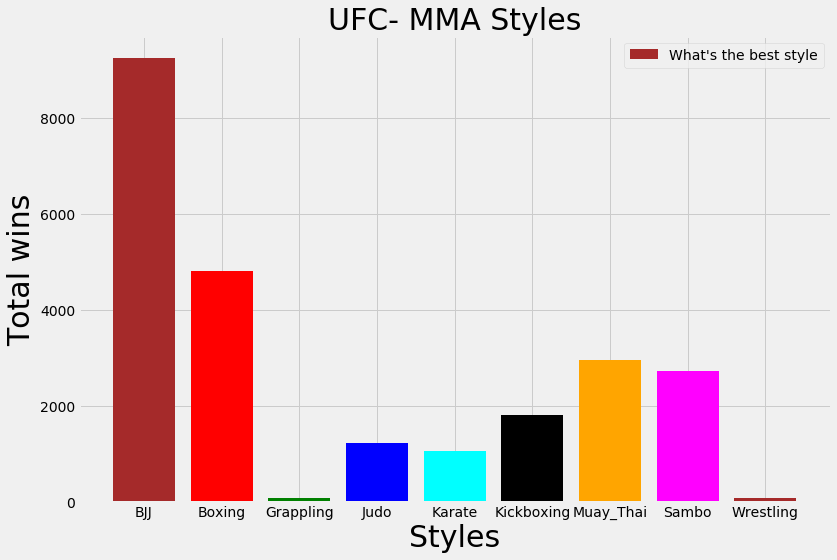

In [101]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
plt.bar(Win_style['Style'],Win_style['Wins'], label="What's the best style", color=['brown', 'red', 'green', 'blue', 'cyan', 'black', 'orange', 'magenta'])
plt.legend()
plt.xlabel('Styles', size = 30)
plt.ylabel('Total wins', size = 30)
plt.title('UFC- MMA Styles', size = 30)
plt.savefig('main_bar_graph.jpg', bbox_inches = 'tight')
plt.show()

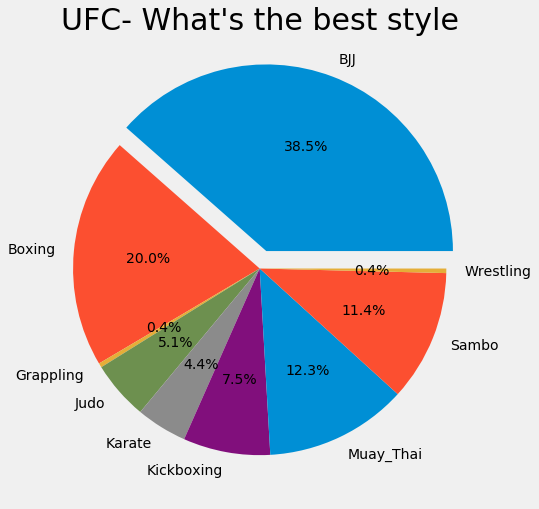

In [102]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 8))
plt.pie(Win_style['Wins'], labels = Win_style['Style'], radius= 1, autopct ='%0.1f%%', explode = [0.1,0,0,0,0,0,0,0,0])
plt.title('UFC- What\'s the best style', size = 30)
plt.savefig('main_Pie_chart.jpg', bbox_inches = 'tight')
plt.show()

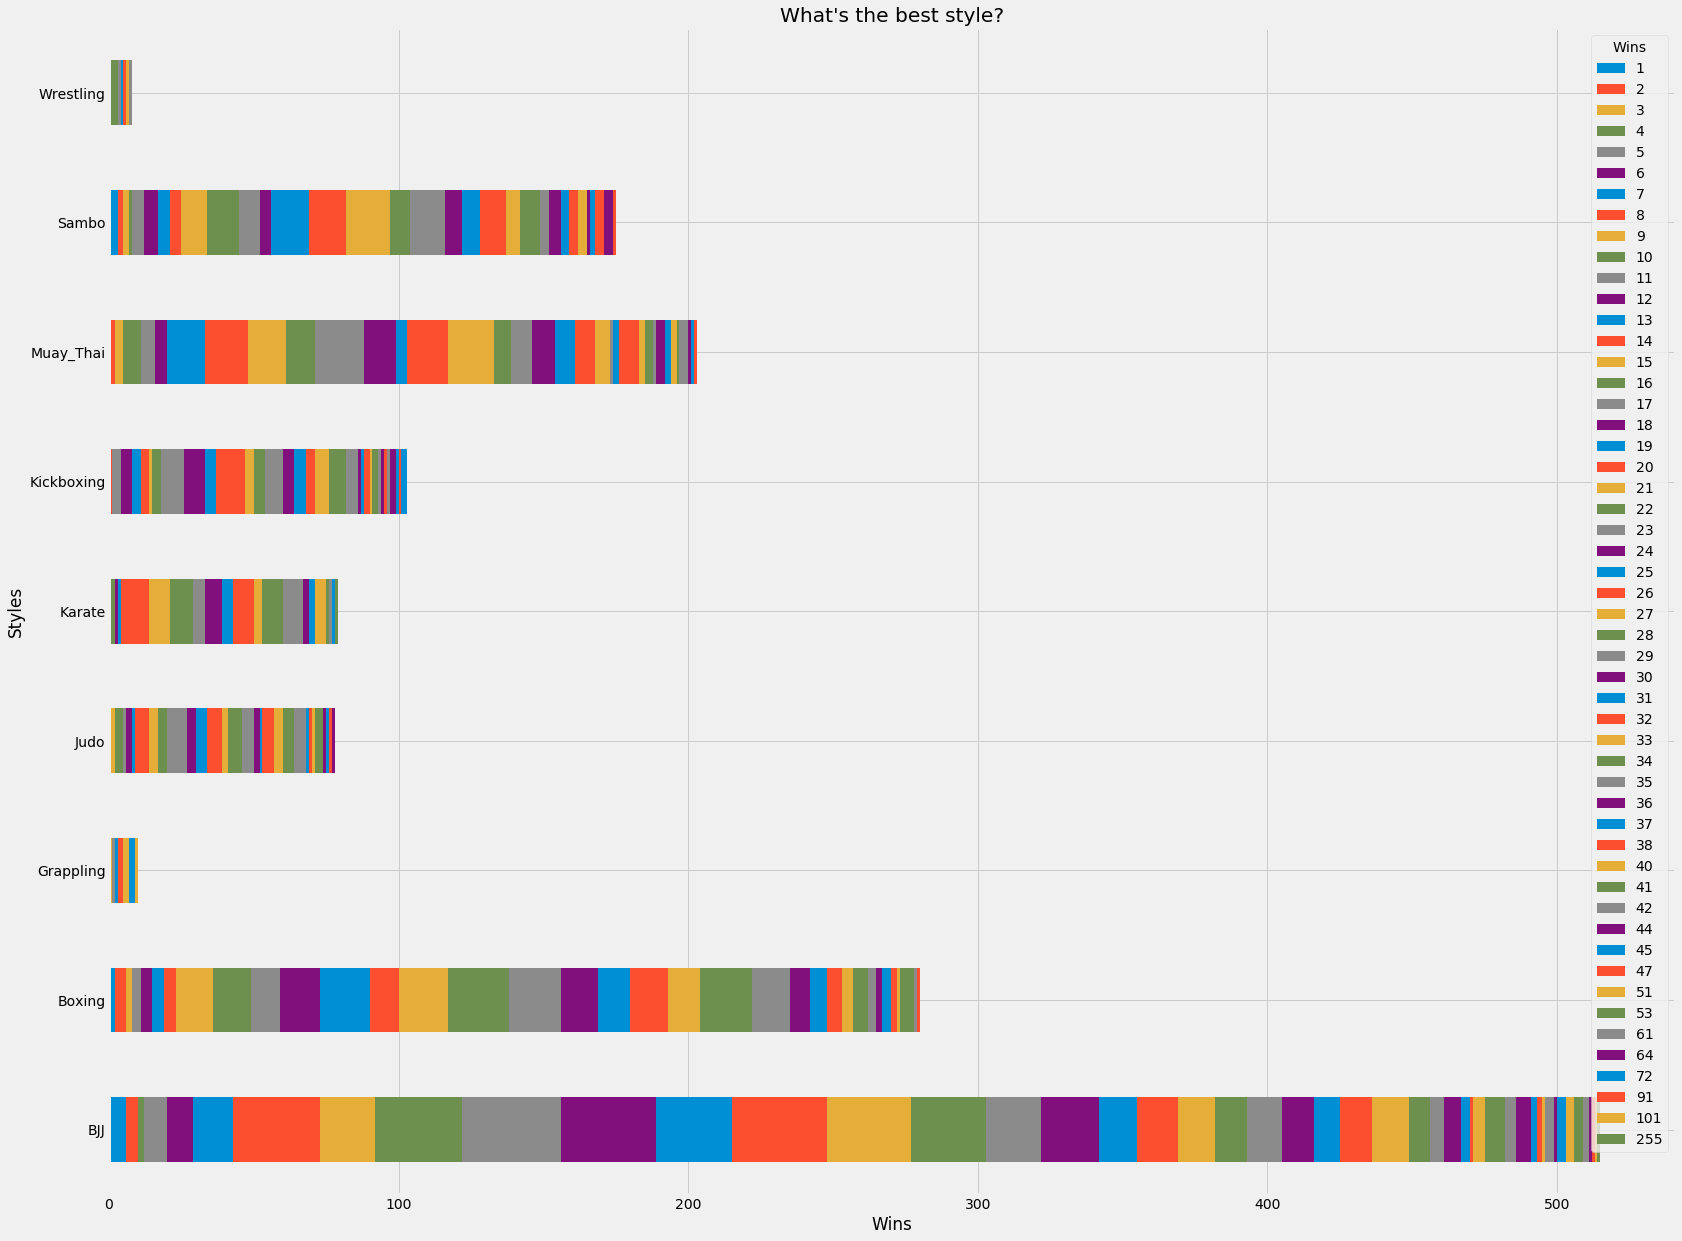

In [103]:
#Different shade of color here represent a single fighter's win in that style.
win_style = Try.groupby(['Wins','Style'])['Wins'].count().unstack(0).plot.barh(title="What's the best style?", figsize=(25,20),stacked = True)
_ = win_style.set_xlabel('Wins')
_ = win_style.set_ylabel('Styles')
win_style.figure.savefig('main_stacked.jpg')

In [163]:
a = fights[['Fighter_name','Result', 'Date', 'Round', 'Time']].copy(deep = True)

In [164]:
b = Try[['Name','Style']].copy(deep = True)

In [165]:
a.columns = ['Name','Result', 'Date', 'Round', 'Time']

In [166]:
a =a.merge(b, on = 'Name'); a['Date']=a['Date'].str.extract(r'(\d{4})'); 

In [167]:
a['Result']= [1 if x=='Win' else 0 for x in a['Result']]

In [168]:
a.head()

,Name,Result,Date,Round,Time,Style
0,Leon Edwards,1,2019,5,5:00,Boxing
1,Leon Edwards,1,2019,3,5:00,Boxing
2,Leon Edwards,1,2018,5,5:00,Boxing
3,Leon Edwards,1,2018,3,4:59,Boxing
4,Leon Edwards,1,2017,3,5:00,Boxing


# Date vs Style vs Wins

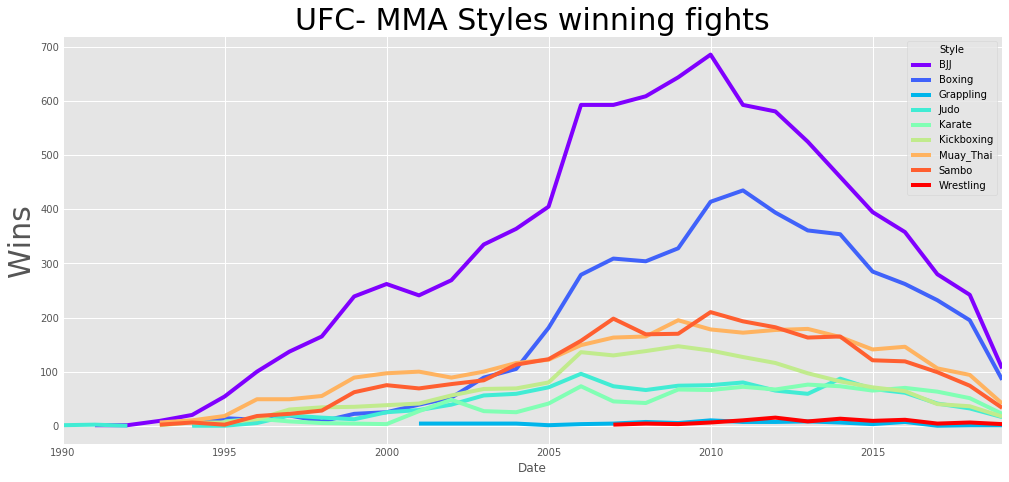

In [169]:
# plot data
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(15,7))
colors = cm.rainbow(np.linspace(0, 1, 9))
plt.ylabel('Wins', size = 30)
plt.title('UFC- MMA Styles winning fights', size = 30)
a[['Date', 'Style','Result']].groupby(['Date', 'Style']).sum()['Result'].unstack().plot(ax=ax,color = colors)
plt.savefig('StyleFlow.jpg', bbox_inches = 'tight')

# Match Length throughout the years

In [170]:
a.isnull().sum(axis =0)

Name         0
Result       0
Date         1
Round      222
Time      1479
Style        0
dtype: int64

In [171]:
a= a.dropna(subset =['Time','Round']).reset_index()
a.isnull().sum(axis =0)


index     0
Name      0
Result    0
Date      1
Round     0
Time      0
Style     0
dtype: int64

In [172]:
a.head()

,index,Name,Result,Date,Round,Time,Style
0,0,Leon Edwards,1,2019,5,5:00,Boxing
1,1,Leon Edwards,1,2019,3,5:00,Boxing
2,2,Leon Edwards,1,2018,5,5:00,Boxing
3,3,Leon Edwards,1,2018,3,4:59,Boxing
4,4,Leon Edwards,1,2017,3,5:00,Boxing


In [175]:
#Generating total time
ooo = []
for i in range(len(a['Time'])):
    if ':' in a['Time'][i]:
        oo= a['Time'][i].split(':')
    elif';' in a['Time'][i]:
        oo = a['Time'][i].split(';')
    else:
        oo = a['Time'][i].split('.')
    try:
        ooo += [(int(oo[0])*60+int(oo[1]))*int(a['Round'][i])/60]
    except:
        ooo+= [float('Nan')]  
a['totalTime'] = ooo 

In [179]:
#a

In [177]:
a= a.dropna(subset =['totalTime', 'Date']).reset_index()
a.isnull().sum(axis =0)

level_0      0
index        0
Name         0
Result       0
Date         0
Round        0
Time         0
Style        0
totalTime    0
dtype: int64

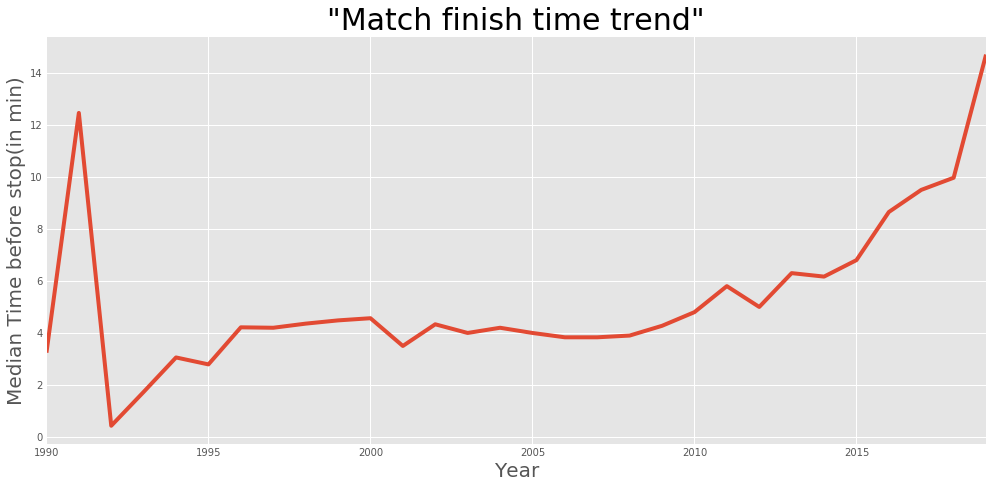

In [178]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(15,7))
a[['Date','totalTime']].groupby('Date').median()['totalTime'].plot(ax=ax)
plt.xlabel('Year', size = 20)
plt.ylabel('Median Time before stop(in min)', size = 20)
plt.title('\"Match finish time trend\"', size = 30)
plt.savefig('Finish_time.jpg', bbox = 'tight')
plt.show()

# Which style has more champions?


In [181]:
champion = pd.read_csv('findchampion', header = None)

In [201]:
aka=[champion[0][i].split('<SEPARATOR>')for i in range(len(champion))]

In [212]:
championList=[]
for i in range(len(aka)):
    if '(c)' in aka[i][0]:
        championList.append(aka[i][0])
    

In [273]:
championList = [championList[i].strip(' (c) ') for i in range(len(championList))]
#championList

In [255]:
champDict ={}
for champ in championList:
    champDict[champ] =Try.loc[Try.Name.str.contains(champ), 'Style'].values[0]


In [267]:
#champDict
aaaaa = Counter(champDict.values())

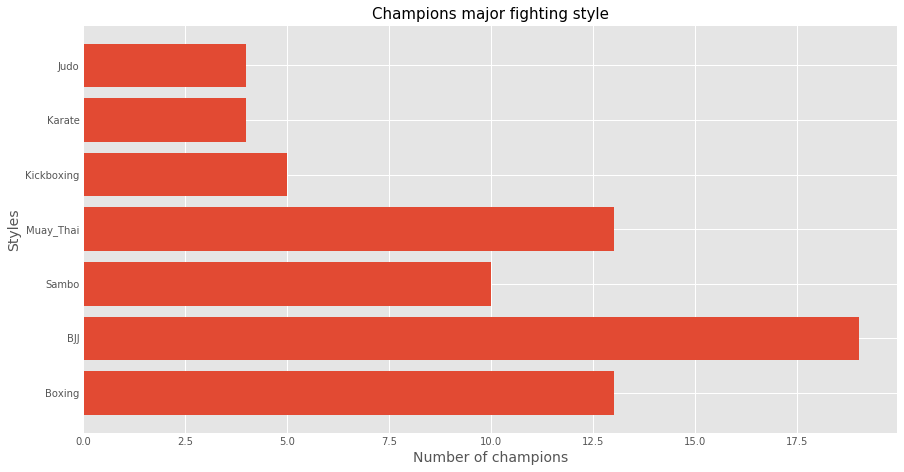

In [279]:
plt.figure(figsize = (13,7))
plt.barh(*zip(*aaaaa.items()))
plt.title('Champions major fighting style', size=15)
plt.xlabel('Number of champions', size =14)
plt.ylabel('Styles', size = 14)
plt.savefig('Champions\' style.jpg', bbox = 'tight')
plt.show()

# Saving the cleaned files.

In [117]:
tosave= pd.merge(fighters.drop(['Style','Age'],axis=1),Try.drop(['Win_Method'],axis =1),on = 'Name')

In [118]:
tosave.head()

,Name,Height,Weight,Division,Reach,Birth_date,ID,Style,Wins
0,Leon Edwards,74.0,170.0,Middleweight,74.0,1991-08-25,852,Boxing,18
1,Rafael dos Anjos,68.0,170.0,Welterweight,70.0,1984-10-26,1138,BJJ,29
2,Walt Harris,77.0,258.0,Heavyweight,81.0,1983-06-10,1437,Karate,13
3,Aleksei Oleinik,74.0,235.0,Heavyweight,80.0,1977-06-25,28,BJJ,34
4,Greg Hardy,77.0,265.0,Heavyweight,80.5,1988-07-28,519,Boxing,5


In [119]:
header = ["Name", "Height", "Weight", "Division", "Reach","Birth_date", "ID", "Style","Wins"]
tosave.to_csv("fighters.csv", columns = header, index = False)

In [120]:
fights.head()

,Fighter_name,Result,Record,Opponent,Method,Event,Date,Round,Time
0,Leon Edwards,Win,18–3,Rafael dos Anjos,Decision (unanimous),UFC on ESPN: dos Anjos vs. Edwards,20 July 2019,5,5:00
1,Leon Edwards,Win,17–3,Gunnar Nelson,Decision (split),UFC Fight Night: Till vs. Masvidal,16 March 2019,3,5:00
2,Leon Edwards,Win,16–3,Donald Cerrone,Decision (unanimous),UFC Fight Night: Cowboy vs. Edwards,23 June 2018,5,5:00
3,Leon Edwards,Win,15–3,Peter Sobotta,TKO (punches),UFC Fight Night: Werdum vs. Volkov,17 March 2018,3,4:59
4,Leon Edwards,Win,14–3,Bryan Barberena,Decision (unanimous),UFC Fight Night: Volkov vs. Struve,2 September 2017,3,5:00


In [121]:
header = ["Fighter_name", "Result", "Record", "Opponent", "Method","Event", "Date", "Round","Time"]
fights.to_csv("fights.csv", columns = header, index = False)